In [ ]:
import gensim
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as sps
import pickle
import yfinance as yf
import math


from tqdm import tqdm
from gensim.models import KeyedVectors
from datetime import datetime
from collections import Counter

sns.set_style("whitegrid")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_train = pd.read_pickle("/content/drive/MyDrive/ML_EPFL_Project/train.pkl")
df_train.drop(columns='class', inplace=True)
df_train.head()

,date,exchange,q,ticker,transcript,daily_r,weekly_r,monthly_r
2980,2020-02-25 00:00:00,NASDAQ: CBRL,2020-Q2,CBRL,prepared remark operator good day welcome crac...,-0.054706,-0.151765,-0.500647
10025,2019-08-08 00:00:00,NASDAQ: DHC,2019-Q2,DHC,prepared remark operator good morning welcome ...,0.066991,0.096224,0.058465
2341,2021-04-16 00:00:00,NYSE: CFG,2021-Q1,CFG,prepared remark operator good morning everyone...,-0.008828,0.013021,0.104171
6733,2019-07-23 00:00:00,NASDAQ: ASTE,2019-Q2,ASTE,prepared remark operator greeting welcome aste...,-0.004375,0.020625,-0.140312
14835,2022-05-09 00:00:00,NYSE: ESE,2022-Q2,ESE,prepared remark operator good day welcome esco...,0.047190,0.072260,0.015238


In [ ]:
df_train.describe()

,daily_r,weekly_r,monthly_r,class_d,class_w,class_m
count,10586.000000,10586.000000,10586.000000,10586.000000,10586.000000,10586.000000
mean,0.000048,0.003373,-0.000025,2.021066,2.043454,1.983374
std,0.067320,0.111156,0.188978,1.520395,1.535719,1.555616
min,-0.762240,-0.818240,-0.857920,0.000000,0.000000,0.000000
25%,-0.029479,-0.051504,-0.092808,1.000000,0.000000,0.000000
50%,0.000452,0.003468,0.000954,2.000000,2.000000,2.000000
75%,0.030831,0.054975,0.086037,4.000000,4.000000,4.000000
max,0.784337,0.851243,5.565916,4.000000,4.000000,4.000000


In [ ]:
def get_class(x, p1, p2):
    if x >= p1:
      return 4
    elif x >= p2:
      return 3
    elif x <= -p1:
      return 0
    elif x <= -p2:
      return 1
    else:
      return 2


df_train['class_d'] = df_train.daily_r.apply(get_class, args=(0.03, 0.01))
df_train['class_w'] = df_train.weekly_r.apply(get_class, args=(0.05, 0.02))
df_train['class_m'] = df_train.monthly_r.apply(get_class, args=(0.08, 0.03))

df_train.head()

,date,exchange,q,ticker,transcript,daily_r,weekly_r,monthly_r,class_d,class_w,class_m
2980,2020-02-25 00:00:00,NASDAQ: CBRL,2020-Q2,CBRL,prepared remark operator good day welcome crac...,-0.054706,-0.151765,-0.500647,0,0,0
10025,2019-08-08 00:00:00,NASDAQ: DHC,2019-Q2,DHC,prepared remark operator good morning welcome ...,0.066991,0.096224,0.058465,4,4,3
2341,2021-04-16 00:00:00,NYSE: CFG,2021-Q1,CFG,prepared remark operator good morning everyone...,-0.008828,0.013021,0.104171,2,2,4
6733,2019-07-23 00:00:00,NASDAQ: ASTE,2019-Q2,ASTE,prepared remark operator greeting welcome aste...,-0.004375,0.020625,-0.140312,2,3,0
14835,2022-05-09 00:00:00,NYSE: ESE,2022-Q2,ESE,prepared remark operator good day welcome esco...,0.047190,0.072260,0.015238,4,4,2


<Axes: >

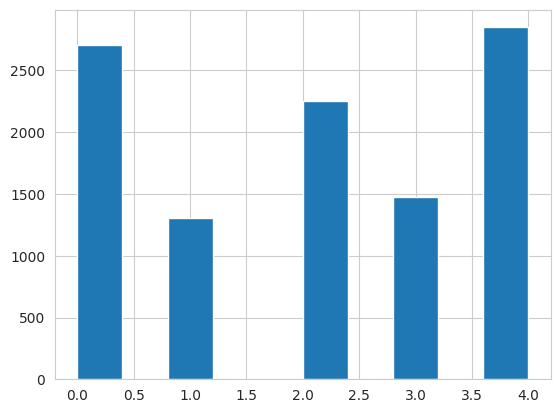

In [ ]:
df_train.class_w.hist()

In [ ]:
token_counts = Counter()
df_train.transcript.apply(lambda x: token_counts.update(x.split(' ')))

2980     None
10025    None
2341     None
6733     None
14835    None
         ... 
9829     None
15706    None
11329    None
12758    None
8456     None
Name: transcript, Length: 10586, dtype: object

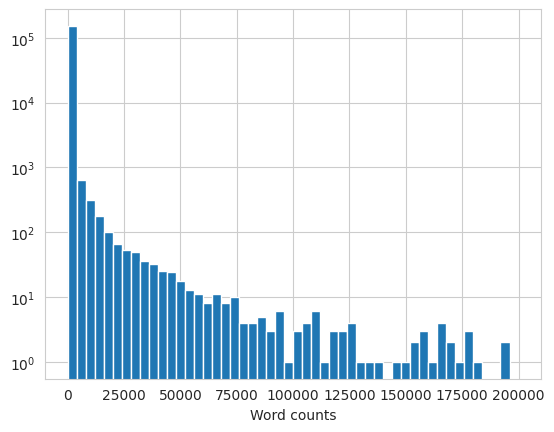

In [ ]:
plt.hist(list(token_counts.values()), range=[0, 2 * 10**5],
         bins=50, log=True)
plt.xlabel("Word counts");

In [ ]:
min_count = 10
tokens = sorted(t for t, c in token_counts.items() if c >= min_count)
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

len(tokens)

48115

In [ ]:
token_to_id = {w: i for i, w in enumerate(tokens)}

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader


device = 'cuda' if torch.cuda.is_available() else 'cpu'
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])
TARGET_COLUMN = 'class_w'


def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])


class CustomTranscriptDataset(Dataset):
    def __init__(self, data, max_len, word_dropout=0, device=device):
        self.data = data
        self.max_len = max_len
        self.word_dropout = word_dropout
        self.device = device

    def __len__(self):
        return self.data.shape[0]

    def len(self):
        return self.data.shape[0]

    def get_weights(self):
        class_sample_count = self.data.groupby(by=TARGET_COLUMN).count()['date'].to_numpy()
        weight = 1. / class_sample_count
        sample_weights = np.array([weight[t] for t in self.data[TARGET_COLUMN]])
        return sample_weights

    def __getitem__(self, idx):
        elem = self.data.iloc[idx]
        transcript = np.array([
            token_to_id.get(word, UNK_IX)
            for word in elem['transcript'].split(' ')[:self.max_len]
        ])

        if self.word_dropout != 0:
            transcript = apply_word_dropout(transcript, 1. - self.word_dropout)

        transcript = torch.tensor(
            transcript, device=self.device,
            dtype=torch.int64)
        label = -1

        if TARGET_COLUMN in self.data.columns:
            label = elem[TARGET_COLUMN]

        label = torch.tensor(label, device=device)

        return transcript, label


class MyCollator(object):
    def __init__(self, max_len):
        self.max_len = max_len

    def __call__(self, batch):
        device = batch[0][0].device
        max_sz = np.max([x.shape[0] for x, _ in batch])
        labels = torch.tensor([x for _, x in batch], device=device)

        sz = min(max_sz, self.max_len)
        matrix = torch.full((len(batch), sz), np.int32(PAD_IX), device=device)
        for i in range(len(batch)):
            row_ix = batch[i][0]
            matrix[i, :len(row_ix)] = row_ix[:sz]

        matrix = matrix.clone().detach().to(device=device, dtype=torch.int64)
        return matrix, labels

In [ ]:
training_data = CustomTranscriptDataset(df_train, 10)
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)

occurences = []

for _, train_labels in tqdm(train_dataloader):
    labels = train_labels.detach().cpu().numpy()

    occurences.append([sum(labels == x) for x in range(5)])

occurences = np.array(occurences)

100%|██████████| 166/166 [00:04<00:00, 34.73it/s]


In [ ]:
sample_weights = training_data.get_weights()
sampler = torch.utils.data.sampler.WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True)

In [ ]:
train_dataloader_v2 = DataLoader(training_data, batch_size=64, sampler=sampler)

occurences_v2 = []

for _, train_labels in tqdm(train_dataloader_v2):
    labels = train_labels.detach().cpu().numpy()

    occurences_v2.append([sum(labels == x) for x in range(5)])

occurences_v2 = np.array(occurences_v2)

100%|██████████| 166/166 [00:04<00:00, 35.78it/s]


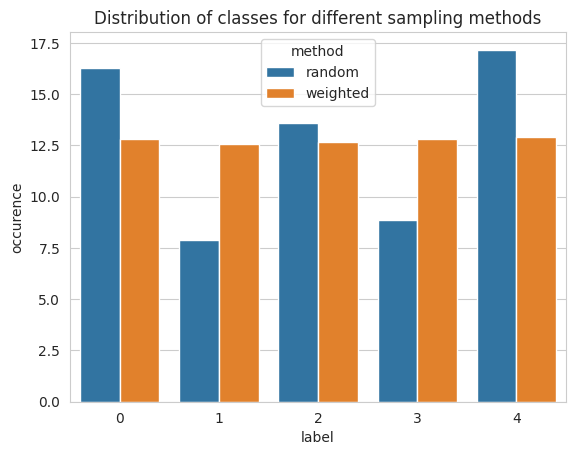

In [ ]:
stat = pd.DataFrame({
    'label': np.arange(5),
    'occurence': occurences.mean(axis=0),
    'method': ['random'] * 5,
})

stat = pd.concat([stat, pd.DataFrame({
    'label': np.arange(5),
    'occurence': occurences_v2.mean(axis=0),
    'method': ['weighted'] * 5,
})], ignore_index=True)

plt.figure()
plt.title("Distribution of classes for different sampling methods")
sns.barplot(stat, x='label', y='occurence', hue='method')
plt.show()

In [ ]:
class TranscriptModule(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_filters=128, dropout=0.2,
                 filter_sizes=[3], hid_size=64):
        super().__init__()
        self.emb = nn.Embedding(n_tokens, 256)
        self.convs = nn.ModuleList([
          nn.Conv1d(
            self.emb.embedding_dim,
            n_filters, fs
          ) for fs in filter_sizes
        ])
        self.fc_conv = nn.Linear((len(filter_sizes) + 1) * n_filters, hid_size)
        self.dropout = nn.Dropout(dropout)

        self.rnn1 = nn.LSTM(self.emb.embedding_dim, n_filters, batch_first=True)
        self.fc_total = nn.Linear(n_filters, hid_size)

    def forward(self, text):
        embedding = self.emb(text)
        output, _ = self.rnn1(embedding)
        output = output.permute(0, 2, 1)
        output = F.avg_pool1d(output, output.shape[2]).squeeze(-1)

        embedding = embedding.permute(0, 2, 1)
        conved = [F.relu(conv(embedding)) for conv in self.convs]
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(-1) for conv in conved]
        pooled.append(output)
        cat = self.dropout(torch.cat(pooled, dim = 1))
        total = F.relu(self.fc_conv(cat))
        return total


class ClassPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), filter_sizes=[3], hid_size=64, num_classes=5):
        super().__init__()
        self.transcriptM = TranscriptModule(n_tokens, filter_sizes=filter_sizes, hid_size=hid_size)
        self.fc = nn.Linear(hid_size, num_classes)
        self

    def forward(self, batch):
        transcript_val = self.transcriptM(batch)
        return self.fc(transcript_val)

    def predict_proba(self, batch):
        ret = self.forward(batch)
        return nn.Softmax(dim=1)(ret)

    def predict_class(self, batch):
        probs = self.predict_proba(batch)
        return probs.argmax(dim=1)

In [ ]:
model = ClassPredictor(filter_sizes=[3, 4, 5], hid_size=128).to(device)
training_data = CustomTranscriptDataset(df_train[:100], max_len=50) #8000
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)

batch, labels = next(iter(train_dataloader))
criterion = nn.CrossEntropyLoss()

dummy_pred = model(batch)
dummy_pred.shape
dummy_loss = criterion(dummy_pred, labels)
assert dummy_pred.shape == torch.Size([64, 5])

In [ ]:
from tqdm.auto import tqdm
from IPython.display import clear_output
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


BATCH_SIZE = 32
EPOCHS = 5


def print_metrics(
      model, dataloader,
      histoty_ce,
      batch_size=BATCH_SIZE,
      name="", num_labels=5, **kw
    ):
    loss = num_samples = 0.0
    criterion = nn.CrossEntropyLoss(reduction='sum')

    real_labels = []
    pred_labels = []
    model.eval()
    with torch.no_grad():
        for batch, labels in dataloader:
            batch_pred = model(batch)
            loss += criterion(batch_pred, labels)
            num_samples += len(batch_pred)

            pred_labels.extend(model.predict_class(batch).detach().cpu().tolist())
            real_labels.extend(labels.detach().cpu().tolist())

    real_labels = np.array(real_labels)
    pred_labels = np.array(pred_labels)

    cm = confusion_matrix(real_labels, pred_labels)

    stats = pd.DataFrame({
        'label': np.arange(num_labels),
        'occurence': [sum(real_labels==x) for x in range(num_labels)],
        'type': 'real',
    })

    stats = pd.concat([stats, pd.DataFrame({
        'label': np.arange(num_labels),
        'occurence': [sum(pred_labels==x) for x in range(num_labels)],
        'type': 'predicted',
    })])

    loss = loss.detach().cpu().numpy() / num_samples
    histoty_ce.append(loss)

    clear_output()
    print(f"epoch: {len(histoty_ce)}")
    print("%s results:" % (name or ""))
    print("Current CE loss: %.5f" % loss)

    plt.figure(figsize=(20, 6))

    plt.subplot(1, 3, 1)
    plt.plot(histoty_ce)
    plt.xlabel("Iteration")
    plt.ylabel("CE")
    plt.title("Cross Entropy Loss")

    plt.subplot(1, 3, 2)
    sns.barplot(stats, x='label', y='occurence', hue='type')
    plt.title("Distribution of classes")

    plt.subplot(1, 3, 3)
    sns.heatmap(cm, annot=True, fmt='g')
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.yticks(rotation='horizontal')
    plt.title("Quality of prediction")

    plt.show()

    return loss


In [ ]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(df_train, test_size=0.1, random_state=42)
# data_train = data_train.iloc[:100]
# data_val = data_val.iloc[:50]

data_train = CustomTranscriptDataset(data_train, max_len=8000) #8000
data_val = CustomTranscriptDataset(data_val, max_len=8000) #8000

data_train.len(), data_val.len()

(9527, 1059)

In [ ]:
def trainModel(model, train_dataloader, val_dataloader, optimizer, criterion, num_epochs=5, batch_size=16, **kw):
    val_err = []
    model.train()
    for epoch in range(num_epochs):
        print(f"epoch: {epoch}")
        model.train()
        for i, cur_batch in tqdm(enumerate(train_dataloader),
                total=len(data_train) // batch_size
            ):
            batch, labels = cur_batch
            pred = model(batch)
            loss = criterion(pred, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print_metrics(
            model, val_dataloader,
            val_err,
            batch_size=batch_size,
            device=device,
            **kw
        )



```
# This is formatted as code
```

## Default model with standart batch sampling

epoch: 120
 results:
Current CE loss: 1.50435


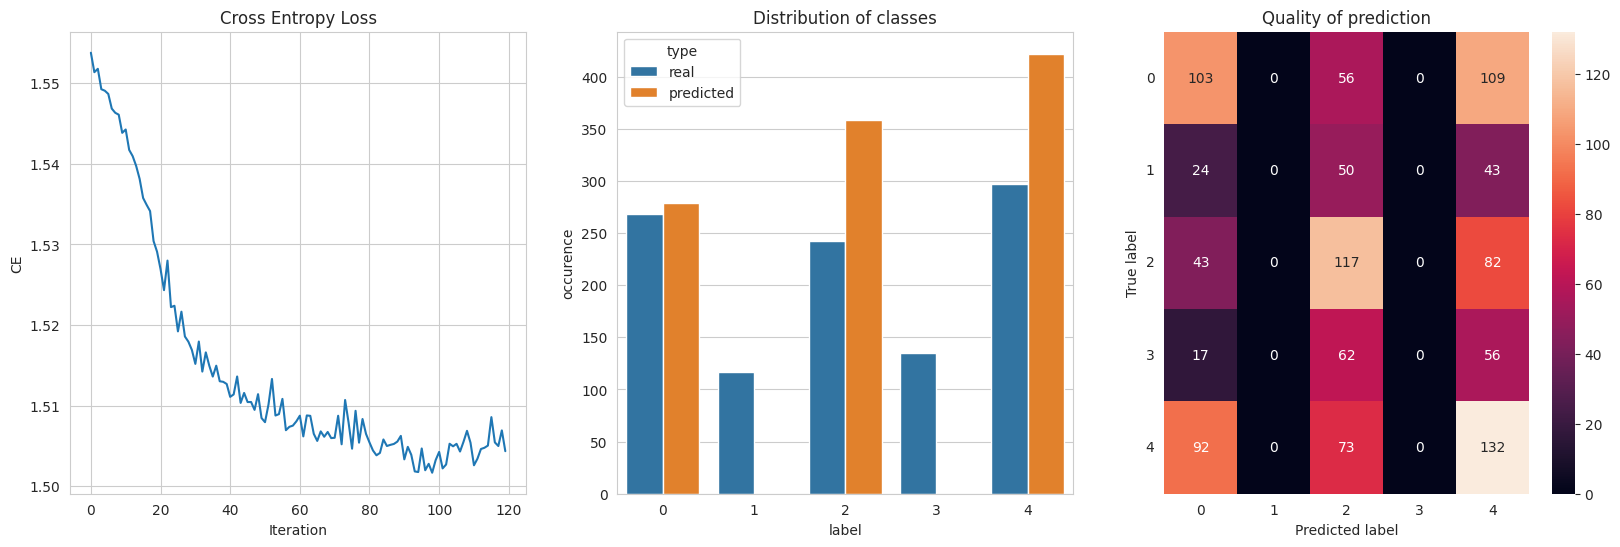

In [ ]:
BATCH_SIZE = 32
EPOCHS = 5

model = ClassPredictor(
    filter_sizes=[3, 4, 5]
).to(device)
criterion = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)


sample_weights = data_train.get_weights()
sampler = torch.utils.data.sampler.WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True)

train_dataloader = DataLoader(data_train, batch_size=32,
                              collate_fn=MyCollator(8000),
                              shuffle=True)#sampler=sampler)
val_dataloader = DataLoader(data_val, batch_size=32,
                            collate_fn=MyCollator(8000),
                            shuffle=False)

trainModel(model, train_dataloader, val_dataloader,
           optimizer, criterion, batch_size=32, num_epochs=120)

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/ML_EPFL_Project/models/rnn_v1.pth')

# Three classes

In [ ]:
def get_class(x, p1):
    if x >= p1:
      return 2
    elif x <= -p1:
      return 0
    else:
      return 1


df_train['class_d'] = df_train.daily_r.apply(get_class, args=(0.02,))
df_train['class_w'] = df_train.weekly_r.apply(get_class, args=(0.04,))
df_train['class_m'] = df_train.monthly_r.apply(get_class, args=(0.06,))

df_train.head()

,date,exchange,q,ticker,transcript,daily_r,weekly_r,monthly_r,class_d,class_w,class_m
2980,2020-02-25 00:00:00,NASDAQ: CBRL,2020-Q2,CBRL,prepared remark operator good day welcome crac...,-0.054706,-0.151765,-0.500647,0,0,0
10025,2019-08-08 00:00:00,NASDAQ: DHC,2019-Q2,DHC,prepared remark operator good morning welcome ...,0.066991,0.096224,0.058465,2,2,1
2341,2021-04-16 00:00:00,NYSE: CFG,2021-Q1,CFG,prepared remark operator good morning everyone...,-0.008828,0.013021,0.104171,1,1,2
6733,2019-07-23 00:00:00,NASDAQ: ASTE,2019-Q2,ASTE,prepared remark operator greeting welcome aste...,-0.004375,0.020625,-0.140312,1,1,0
14835,2022-05-09 00:00:00,NYSE: ESE,2022-Q2,ESE,prepared remark operator good day welcome esco...,0.047190,0.072260,0.015238,2,2,1


In [ ]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(df_train, test_size=0.1, random_state=42)
# data_train = data_train.iloc[:100]
# data_val = data_val.iloc[:50]

data_train = CustomTranscriptDataset(data_train, max_len=8000) #8000
data_val = CustomTranscriptDataset(data_val, max_len=8000) #8000

data_train.len(), data_val.len()

(9527, 1059)

epoch: 120
 results:
Current CE loss: 1.05955


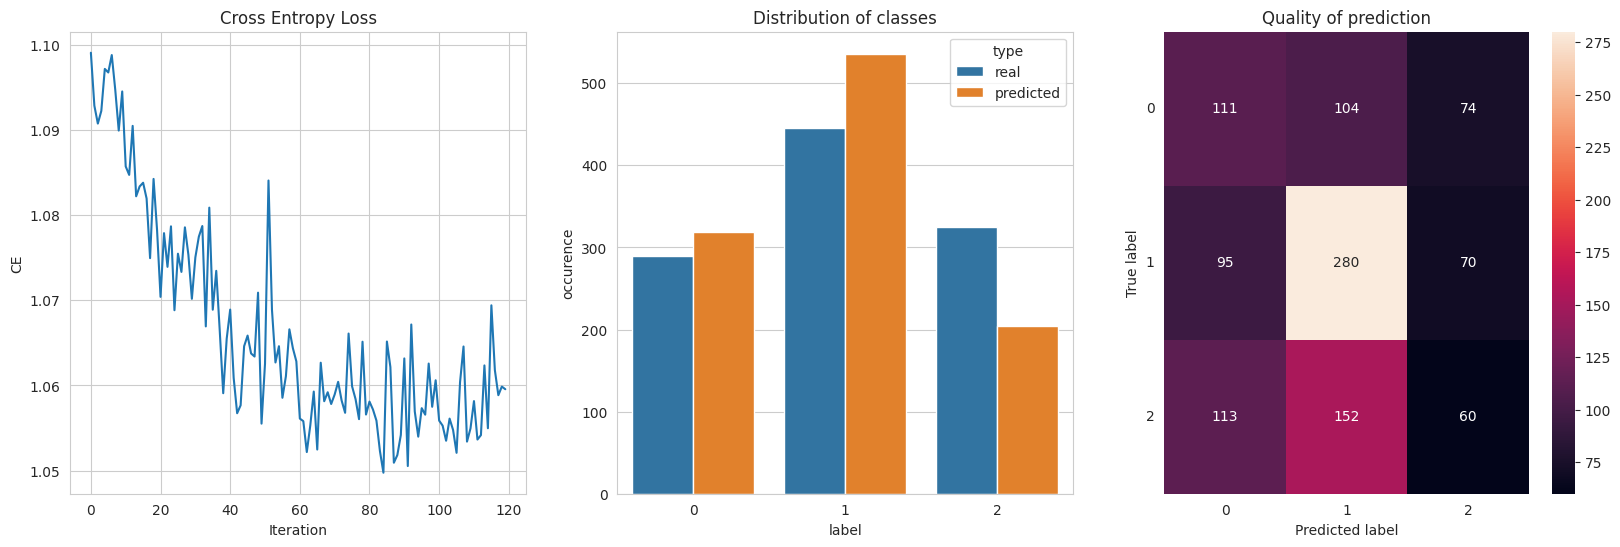

In [ ]:
BATCH_SIZE = 32
EPOCHS = 5

model_eq_class = ClassPredictor(
    filter_sizes=[3, 4, 5],
    num_classes=3
).to(device)
criterion = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(model_eq_class.parameters(), lr=1e-5)


sample_weights = data_train.get_weights()
sampler = torch.utils.data.sampler.WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True)

train_dataloader = DataLoader(data_train, batch_size=32,
                              collate_fn=MyCollator(8000),
                              sampler=sampler)
val_dataloader = DataLoader(data_val, batch_size=32,
                            collate_fn=MyCollator(8000),
                            shuffle=False)


trainModel(model_eq_class, train_dataloader, val_dataloader,
           optimizer, criterion, batch_size=32, num_epochs=120, num_labels=3)

In [ ]:
torch.save(model_eq_class.state_dict(), '/content/drive/MyDrive/ML_EPFL_Project/models/rnn_v3.pth')

## Generating signals

In [ ]:
df_test = pd.read_pickle("/content/drive/MyDrive/ML_EPFL_Project/test.pkl")
df_test.head()

,date,exchange,q,ticker,transcript,daily_r,weekly_r,monthly_r
5748,2021-07-27 00:00:00,NASDAQ: FELE,2021-Q2,FELE,prepared remark operator good morning lady gen...,-0.006114,0.005258,0.020543
2743,2019-07-02 00:00:00,NYSE: GBX,2019-Q3,GBX,prepared remark operator hello welcome greenbr...,0.027027,0.033514,-0.141622
16479,2022-05-06 00:00:00,NYSE: GTN,2022-Q1,GTN,prepared remark operator good day thank standi...,-0.068500,0.005000,-0.088000
15556,2021-08-05 00:00:00,NASDAQ: DDOG,2021-Q2,DDOG,prepared remark operator welcome q2 2021 datad...,-0.013826,0.029398,0.100957
3413,2021-01-19 00:00:00,NYSE: BAC,2020-Q4,BAC,prepared remark operator good day everyone wel...,0.008000,-0.064000,0.106769


In [ ]:
model_gen = ClassPredictor(
    filter_sizes=[3, 4, 5]
).to(device)
model_gen.load_state_dict(torch.load('/content/drive/MyDrive/ML_EPFL_Project/models/rnn_v1.pth'))
model_gen.eval()

ClassPredictor(
  (transcriptM): TranscriptModule(
    (emb): Embedding(48115, 256)
    (convs): ModuleList(
      (0): Conv1d(256, 128, kernel_size=(3,), stride=(1,))
      (1): Conv1d(256, 128, kernel_size=(4,), stride=(1,))
      (2): Conv1d(256, 128, kernel_size=(5,), stride=(1,))
    )
    (fc_conv): Linear(in_features=512, out_features=64, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (rnn1): LSTM(256, 128, batch_first=True)
    (fc_total): Linear(in_features=128, out_features=64, bias=True)
  )
  (fc): Linear(in_features=64, out_features=5, bias=True)
)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model_gen)

12950085

In [ ]:
data_test = CustomTranscriptDataset(df_test, max_len=8000)
val_dataloader = DataLoader(data_test, batch_size=128,
                            collate_fn=MyCollator(8000),
                            shuffle=False)

classes = []

for batch, _ in tqdm(val_dataloader):
    with torch.no_grad():
        res = model_eq_class.predict_class(batch).detach().cpu().tolist()
        # class_to_coef = {
        #     0: -1, 1: -0.5, 2: 0,
        #     3: 0.5, 4: 1
        # }
        class_to_coef = {
            0: -1, 1: 0, 2: 1,
        }
        classes.extend([class_to_coef[x] for x in res])

  0%|          | 0/41 [00:00<?, ?it/s]

In [ ]:
coefs = pd.DataFrame({
    "alpha": classes
}, index=df_test.index)

coefs.head()

,alpha
5748,0
2743,0
16479,1
15556,-1
3413,0


array([[<Axes: title={'center': 'alpha'}>]], dtype=object)

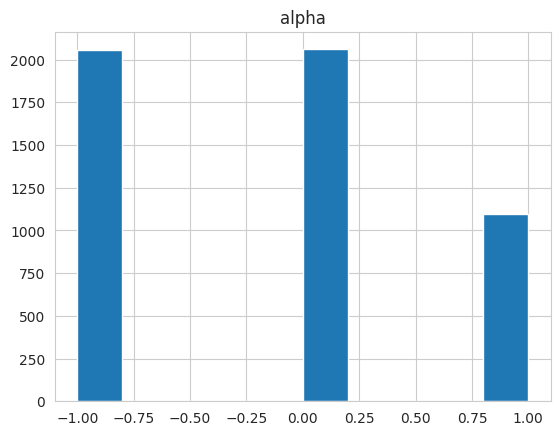

In [ ]:
coefs.hist()

In [ ]:
coefs.to_csv("/content/drive/MyDrive/ML_EPFL_Project/Strategies_coefs/rnn_v3.csv")